In [2]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd

base_url = 'https://www.sports-reference.com'

# Data Frame for all #1 teams
top_teams = pd.DataFrame()

# Looping through every year from 1949 (Start of AP polling) to most recent final AP Poll in 2020
for year in range(1949, 2021):
    # Sports-Reference uses a simple year as the page format
    season_url = base_url + '/cbb/seasons/' + str(year) + '.html'
    season_request = requests.get(season_url).text
    soup = BeautifulSoup(season_request, features='lxml')

    # Find on the page where AP Final #1 is found and extract team page and name
    ap_final = soup.find(text=re.compile('AP Final #1')).parent.parent.parent.find("a")
    team_page_url = ap_final.get("href")
    team_name = ap_final.text

    # Now go into each team page and extra data
    team_page_request = requests.get(base_url + team_page_url).text
    soup = BeautifulSoup(team_page_request, features='lxml')
    table_team_data = soup.find(id="team_stats")
    if table_team_data is None:
        # No team data exists for this team for this season
        continue
    table_team_data = table_team_data.findAll("tr")

    # Create data frame to append to, year will be index
    year = team_page_url[team_page_url.rfind("/") + 1:team_page_url.find(".html")]
    team_data = pd.DataFrame(index=[year])
    team_data['team'] = team_name
    # Gets year from url

    # First row is labels for stats
    # Second row is teams stats for
    for entries in table_team_data[1].findAll("td"):
        stat = entries.get("data-stat")
        team_data[stat] = entries.text

    # Third row is teams stats against. Some years have different third row, so this takes that into account
    against = 2
    if len(table_team_data) > 3:
        against = -2
    for entries in table_team_data[against].findAll("td"):
        stat = entries.get("data-stat") # + '_against'
        team_data[stat] = entries.text

    # Append our row to the ongoing list of AP #1 teams
    top_teams = top_teams.append(team_data)


# Move team name to the front of the df
names = top_teams['team']
top_teams.drop(['team'], axis = 1, inplace = True)
top_teams.insert(0, 'team_name', names)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [3]:
top_teams.columns

Index(['team_name', 'ast', 'blk', 'drb', 'fg', 'fg2', 'fg2_pct', 'fg2a', 'fg3',
       'fg3_pct', 'fg3a', 'fg_pct', 'fga', 'ft', 'ft_pct', 'fta', 'g', 'mp',
       'opp_ast', 'opp_blk', 'opp_drb', 'opp_fg', 'opp_fg2', 'opp_fg2_pct',
       'opp_fg2a', 'opp_fg3', 'opp_fg3_pct', 'opp_fg3a', 'opp_fg_pct',
       'opp_fga', 'opp_ft', 'opp_ft_pct', 'opp_fta', 'opp_orb', 'opp_pf',
       'opp_pts', 'opp_pts_per_g', 'opp_stl', 'opp_tov', 'opp_trb', 'orb',
       'pf', 'pts', 'pts_per_g', 'stl', 'tov', 'trb'],
      dtype='object')

In [4]:
top_teams.tail()

,team_name,ast,blk,drb,fg,fg2,fg2_pct,fg2a,fg3,fg3_pct,...,opp_stl,opp_tov,opp_trb,orb,pf,pts,pts_per_g,stl,tov,trb
2016,Kansas,604,158,1041,1092,788,.533,1479,304,.418,...,248,490,1234,402,719,3089,81.3,253,478,1443
2017,Villanova,505,109,892,965,654,.592,1105,311,.369,...,185,475,1073,316,515,2779,77.2,259,402,1208
2018,Virginia,458,124,817,848,601,.501,1199,247,.383,...,130,432,1048,282,480,2283,67.1,232,290,1099
2019,Duke,606,257,1072,1157,879,.580,1515,278,.308,...,243,540,1348,495,595,3143,82.7,346,488,1567
2020,Kansas,432,145,863,851,652,.553,1180,199,.344,...,199,407,991,333,454,2312,74.6,237,396,1196


There is now an abundance of CBB data from each season's AP Poll 'Best Team' for each season starting at 1949 loaded into the top_teams DataFrame. All of the columns for statistics from the team's opponent start with the opp_ prefix. For example, the Total Rebounds statistic is kept under the 'trb' column, but opponent total rebounds are kept under the 'opp_trb' column. Additionally, the index of the row is the year in which the season was played. Furthermore, the final row in the DataFrame is the from 2019-2020 season.

# Data Processing
Let's convert all of the columns to their proper datatypes. A float is necessary for columns that are percentages or per game values. Integers will suffice for the rest.

In [5]:
# Convert non-name columns to float or int
import numpy as np
from plotnine import *

top_teams.replace(r'^\s*$', np.nan, regex=True, inplace = True)
for column in top_teams:
    if not column == 'team_name':
        top_teams[column] = top_teams[column].fillna(-1)
        if ('pct' in column) or ('per_g' in column):
            top_teams[column] = top_teams[column].astype(float)
        else:
            top_teams[column] = top_teams[column].astype(int)
    print(column + " type is " + str(type(top_teams[column][-1])))

team_name type is <class 'str'>
ast type is <class 'numpy.int64'>
blk type is <class 'numpy.int64'>
drb type is <class 'numpy.int64'>
fg type is <class 'numpy.int64'>
fg2 type is <class 'numpy.int64'>
fg2_pct type is <class 'numpy.float64'>
fg2a type is <class 'numpy.int64'>
fg3 type is <class 'numpy.int64'>
fg3_pct type is <class 'numpy.float64'>
fg3a type is <class 'numpy.int64'>
fg_pct type is <class 'numpy.float64'>
fga type is <class 'numpy.int64'>
ft type is <class 'numpy.int64'>
ft_pct type is <class 'numpy.float64'>
fta type is <class 'numpy.int64'>
g type is <class 'numpy.int64'>
mp type is <class 'numpy.int64'>
opp_ast type is <class 'numpy.int64'>
opp_blk type is <class 'numpy.int64'>
opp_drb type is <class 'numpy.int64'>
opp_fg type is <class 'numpy.int64'>
opp_fg2 type is <class 'numpy.int64'>
opp_fg2_pct type is <class 'numpy.float64'>
opp_fg2a type is <class 'numpy.int64'>
opp_fg3 type is <class 'numpy.int64'>
opp_fg3_pct type is <class 'numpy.float64'>
opp_fg3a type is 

In [6]:
top_teams.head()

,team_name,ast,blk,drb,fg,fg2,fg2_pct,fg2a,fg3,fg3_pct,...,opp_stl,opp_tov,opp_trb,orb,pf,pts,pts_per_g,stl,tov,trb
1949,Kentucky,-1,-1,-1,903,-1,-1.0,-1,-1,-1.0,...,-1,1530,-1,-1,636,2320,68.2,-1,-1,-1
1951,Kentucky,471,-1,-1,1029,-1,-1.0,-1,-1,-1.0,...,-1,-1,1357,-1,684,2540,74.7,-1,-1,2109
1952,Kentucky,497,-1,-1,1043,-1,-1.0,-1,-1,-1.0,...,-1,-1,1164,-1,707,2635,82.3,-1,-1,1817
1953,Indiana,-1,-1,-1,737,-1,-1.0,-1,-1,-1.0,...,-1,-1,792,-1,620,2112,81.2,-1,-1,1005
1954,Kentucky,-1,-1,-1,829,-1,-1.0,-1,-1,-1.0,...,-1,-1,851,-1,582,2187,87.5,-1,-1,1318


In [7]:
top_teams.tail()

,team_name,ast,blk,drb,fg,fg2,fg2_pct,fg2a,fg3,fg3_pct,...,opp_stl,opp_tov,opp_trb,orb,pf,pts,pts_per_g,stl,tov,trb
2016,Kansas,604,158,1041,1092,788,0.533,1479,304,0.418,...,248,490,1234,402,719,3089,81.3,253,478,1443
2017,Villanova,505,109,892,965,654,0.592,1105,311,0.369,...,185,475,1073,316,515,2779,77.2,259,402,1208
2018,Virginia,458,124,817,848,601,0.501,1199,247,0.383,...,130,432,1048,282,480,2283,67.1,232,290,1099
2019,Duke,606,257,1072,1157,879,0.580,1515,278,0.308,...,243,540,1348,495,595,3143,82.7,346,488,1567
2020,Kansas,432,145,863,851,652,0.553,1180,199,0.344,...,199,407,991,333,454,2312,74.6,237,396,1196


As you can see, all of the missing data has been encoded as -1, but the recent data is much more complete. 
Now that the data is in it's proper datatype, we can start exploring it.

# Exploratory Data Analysis
Let's start by finding out which schools have been the most successful at producing the AP Poll #1 Ranked team at the end of each season.

In [8]:
# Let's see which colleges have been AP Poll #1 ranked the most often, after each season
counts = top_teams.filter(['team_name', 'pts']).groupby(['team_name']).count()
counts['team_name'] = counts.index
counts.reset_index(drop = True, inplace = True)
counts.sort_values(by=['pts'], ascending = False, inplace = True)

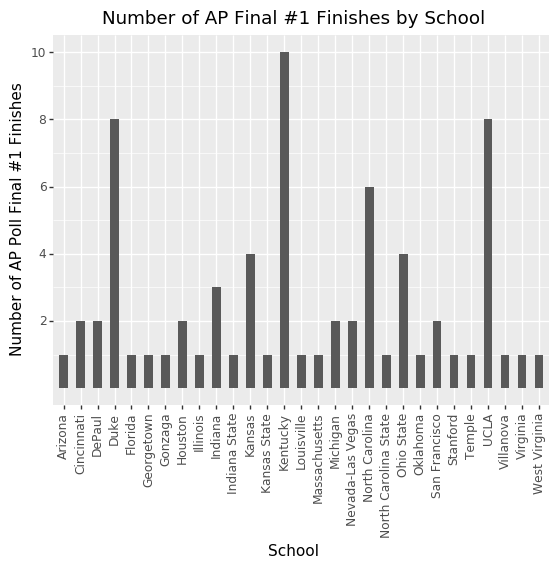

<ggplot: (281867881)>

In [9]:
(ggplot(counts, aes(x= 'team_name', y = 'pts')) +
theme(axis_text_x = element_text(angle=90)) +
xlab('School') + 
ylab('Number of AP Poll Final #1 Finishes') +
ggtitle('Number of AP Final #1 Finishes by School') +
scale_y_continuous(breaks=[2, 4, 6, 8, 10]) +
geom_col(width = 0.5))

Kentucky has acheived this feat a whopping 10 times. Duke and UCLA aren't far behind with 8 times, with North Carolina, Kansas, and Ohio State behind them at 4 times.

In [10]:
# Let's see how some key parts of basketball have changed over time. Let's start with points.
points = top_teams.filter(['team_name', 'pts_per_g', 'opp_pts_per_g'])
points['year'] = points.index.astype(int)
points.reset_index(drop = True, inplace = True)
points['differential'] = points['pts_per_g'] - points['opp_pts_per_g']
points.tail()

,team_name,pts_per_g,opp_pts_per_g,year,differential
66,Kansas,81.3,67.6,2016,13.7
67,Villanova,77.2,62.7,2017,14.5
68,Virginia,67.1,54.0,2018,13.1
69,Duke,82.7,67.8,2019,14.9
70,Kansas,74.6,60.7,2020,13.9


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


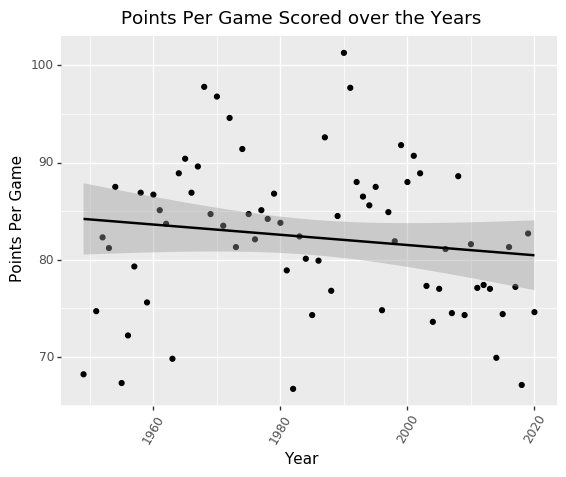

<ggplot: (7555681881)>

In [11]:
(ggplot(points, aes(x= 'year', y = 'pts_per_g')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('Points Per Game') +
ggtitle('Points Per Game Scored over the Years') +
geom_smooth(method = 'lm'))

In [12]:
import statsmodels.formula.api as sm
ppg_res = sm.ols('year~pts_per_g', data=points).fit()
ppg_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   year   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.409
Date:                Sat, 16 May 2020   Prob (F-statistic):              0.239
Time:                        12:51:41   Log-Likelihood:                -314.54
No. Observations:                  71   AIC:                             633.1
Df Residuals:                      69   BIC:                             637.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2016.2214     26.426     76.295      0.000    1963.502    2068.941
pts_per_g     -0.3795      0.320     -1.187      0.239      -1.017       0.258
==============================================================================
Omnibus:                       13.220   Durbin-Watson:                   0.030
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                3.928
Skew:                          -0.185   Prob(JB):                        0.140
Kurtosis:                       1.909   Cond. No.                         893.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From this plot, you can see that there may be a slight drop in points per game over the years by CBB's best teams. 
However, by checking the summary of this model, there is no statistically significant difference we can detect. 

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


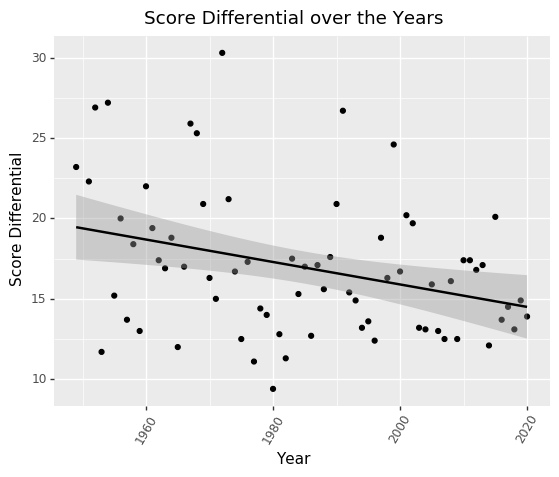

<ggplot: (7556670453)>

In [13]:
(ggplot(points, aes(x= 'year', y = 'differential')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('Score Differential') +
ggtitle('Score Differential over the Years') +
geom_smooth(method = 'lm'))

In [14]:
diff_res = sm.ols('year~differential', data=points).fit()
diff_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   year   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     8.196
Date:                Sat, 16 May 2020   Prob (F-statistic):            0.00556
Time:                        12:51:41   Log-Likelihood:                -311.27
No. Observations:                  71   AIC:                             626.5
Df Residuals:                      69   BIC:                             631.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2010.7460      9.296    216.297      0.000    1992.201    2029.292
differential    -1.5203      0.531     -2.863      0.006      -2.580      -0.461
==============================================================================
Omnibus:                       15.692   Durbin-Watson:                   0.192
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                3.856
Skew:                          -0.011   Prob(JB):                        0.145
Kurtosis:                       1.858   Cond. No.                         69.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

On the other hand, the best teams aren't winning by nearly as much anymore.
This does have a statistically significant difference, providing a modeling equation of differential = 2010.7460 - 1.5203(year)
with a p-value of .006. In context, this means that over the years, CBB games have gotten closer over time, and the best teams don't blow out their opponents nearly as often.

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


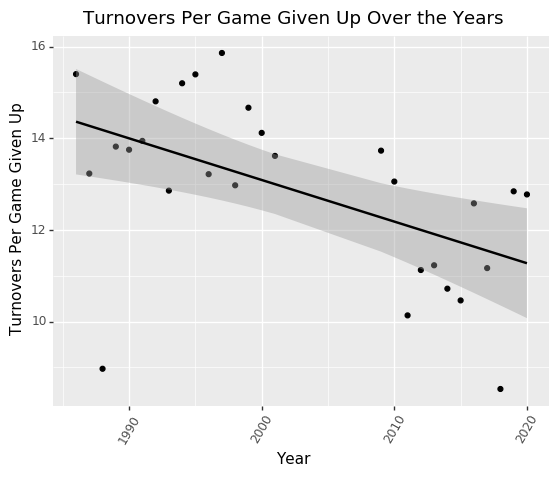

<ggplot: (7556797833)>

In [15]:
turnovers = top_teams.filter(['g','tov', 'opp_tov'])

# Some teams play more games, so we create a new statistic for both forced and given up turnovers per game played
turnovers['tov_per_g'] = turnovers['tov'] / turnovers['g']
turnovers['opp_tov_per_g'] = turnovers['opp_tov'] / turnovers['g']

# Let's also find the differential in turnovers.
turnovers['differential'] = turnovers['opp_tov_per_g'] - turnovers['tov_per_g']

# Convert year to a column
turnovers['year'] = turnovers.index.astype(int)
turnovers.reset_index(drop = True, inplace = True)
turnovers = turnovers[(turnovers != -1).all(1)]

# Plot
(ggplot(turnovers, aes(x= 'year', y = 'tov_per_g')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('Turnovers Per Game Given Up') +
ggtitle('Turnovers Per Game Given Up Over the Years') +
geom_smooth(method = 'lm'))

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


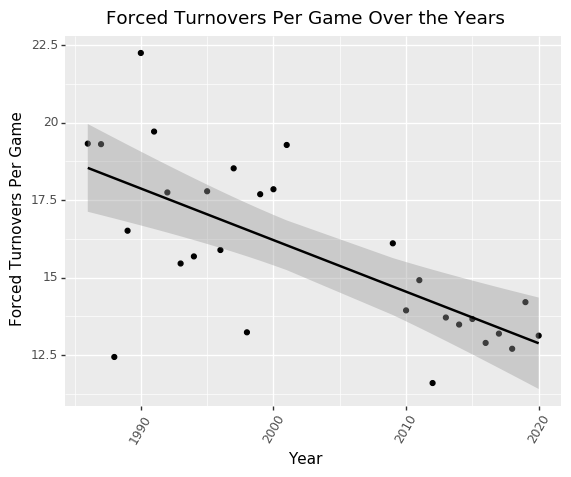

<ggplot: (7556754069)>

In [16]:
(ggplot(turnovers, aes(x= 'year', y = 'opp_tov_per_g')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('Forced Turnovers Per Game') +
ggtitle('Forced Turnovers Per Game Over the Years') +
geom_smooth(method = 'lm'))

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


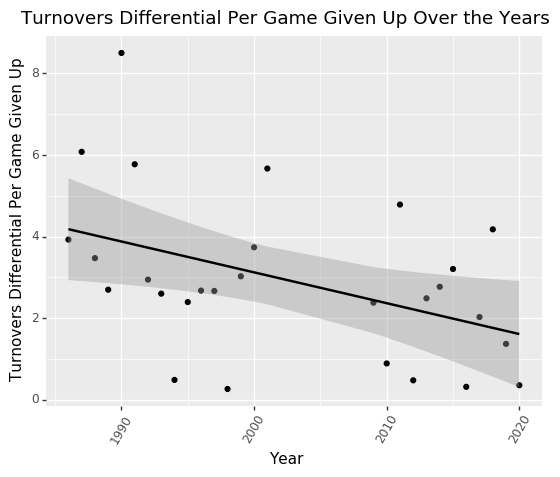

<ggplot: (7556263421)>

In [17]:
(ggplot(turnovers, aes(x= 'year', y = 'differential')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('Turnovers Differential Per Game Given Up') +
ggtitle('Turnovers Differential Per Game Given Up Over the Years') +
geom_smooth(method = 'lm'))

In [19]:
turnover_diff = sm.ols('year~differential', data=turnovers).fit()
turnover_diff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   year   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     6.166
Date:                Sat, 16 May 2020   Prob (F-statistic):             0.0198
Time:                        12:52:39   Log-Likelihood:                -104.38
No. Observations:                  28   AIC:                             212.8
Df Residuals:                      26   BIC:                             215.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2009.9355      3.586    560.462      0.000    2002.564    2017.307
differential    -2.5350      1.021     -2.483      0.020      -4.634      -0.436
==============================================================================
Omnibus:                        7.974   Durbin-Watson:                   0.354
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                2.120
Skew:                           0.088   Prob(JB):                        0.346
Kurtosis:                       1.664   Cond. No.                         6.75
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The change in turnover differential does have a statistically significant difference, providing a modeling equation of differential = 2009.9355 - -2.5350(year) with a p-value of .020. In context, this means that over the years, the best teams protect the ball on offense, knowing that they must not waste possessions by giving it away to the other team. The best teams outplay their opponents in the turnover categories, with the differential being > 0, despite steadily dropping over the years as offenses protect the ball more.

Turnovers have evolved into an important statistic in basketball. The best teams turn over the ball less often per game, but this also leads to their opponents turning the ball over less frequently too. We will see that this smaller number of possessions will lead to the rise of the 3-pointer (a way to score more points per possession than the standard 2 point shot) and promote a more efficient style of basketball.

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


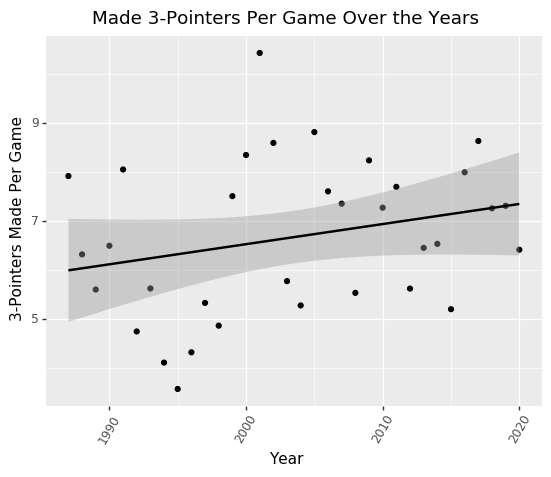

<ggplot: (7556664005)>

In [21]:
threes = top_teams.filter(['g','fg3_pct', 'fg3', 'fg3a'])

# Some teams play more games, so we create a new statistic based on games played
threes['fg3_per_g'] = threes['fg3'] / threes['g']
threes['fg3a_per_g'] = threes['fg3a'] / threes['g']

# Convert year to a column
threes['year'] = threes.index.astype(int)
threes.reset_index(drop = True, inplace = True)
threes = threes[(threes != -1).all(1)]

# Plot
(ggplot(threes, aes(x= 'year', y = 'fg3_per_g')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('3-Pointers Made Per Game') +
ggtitle('Made 3-Pointers Per Game Over the Years') +
geom_smooth(method = 'lm'))

In [22]:
three_point_made = sm.ols('year~fg3_per_g', data=threes).fit()
three_point_made.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   year   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     2.332
Date:                Sat, 16 May 2020   Prob (F-statistic):              0.137
Time:                        13:05:05   Log-Likelihood:                -124.69
No. Observations:                  34   AIC:                             253.4
Df Residuals:                      32   BIC:                             256.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1992.4627      7.419    268.548      0.000    1977.350    2007.576
fg3_per_g      1.6533      1.083      1.527      0.137      -0.552       3.859
==============================================================================
Omnibus:                        2.848   Durbin-Watson:                   0.093
Prob(Omnibus):                  0.241   Jarque-Bera (JB):                1.390
Skew:                          -0.033   Prob(JB):                        0.499
Kurtosis:                       2.012   Cond. No.                         31.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

While the number of made three pointers per game has increased over the years since it's addition to the NCAA in 1986, the jump is not statistically significant with a p-value of 0.137.

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


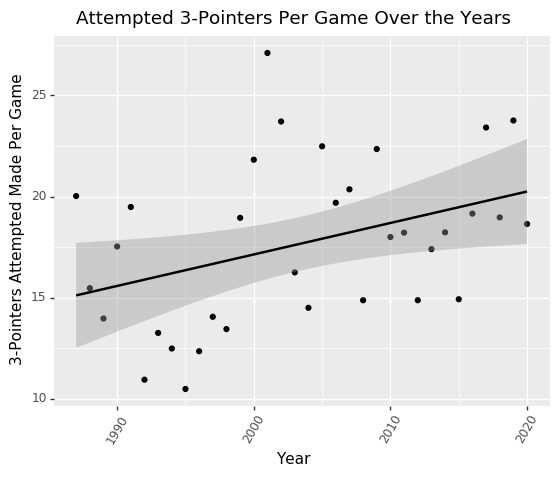

<ggplot: (7555681961)>

In [23]:
(ggplot(threes, aes(x= 'year', y = 'fg3a_per_g')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('3-Pointers Attempted Made Per Game') +
ggtitle('Attempted 3-Pointers Per Game Over the Years') +
geom_smooth(method = 'lm'))

In [24]:
three_point_att = sm.ols('year~fg3a_per_g', data=threes).fit()
three_point_att.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   year   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     5.490
Date:                Sat, 16 May 2020   Prob (F-statistic):             0.0255
Time:                        13:08:09   Log-Likelihood:                -123.19
No. Observations:                  34   AIC:                             250.4
Df Residuals:                      32   BIC:                             253.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1986.8680      7.277    273.035      0.000    1972.045    2001.691
fg3a_per_g     0.9406      0.401      2.343      0.026       0.123       1.758
==============================================================================
Omnibus:                        2.603   Durbin-Watson:                   0.196
Prob(Omnibus):                  0.272   Jarque-Bera (JB):                1.362
Skew:                          -0.097   Prob(JB):                        0.506
Kurtosis:                       2.039   Cond. No.                         82.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

On the other hand, the number of 3 point shots attempted has jumped in a statistically significant way, increasing by almost 1 for every year after 1987. The best teams in the NCAA have realized that the 3 pointer is the best 'bang for your buck shot' when compared to other jumpshots. Why shoot a jump shot from 20ft for 2 points, when you can step back another foot for a 3rd point? It only makes sense. The rising prominence of the three point shot changes the fundamental composition of basketball teams, making it less about height and bullying the other guy at the rim, and more about strategy and spacing of the court and good shooters.

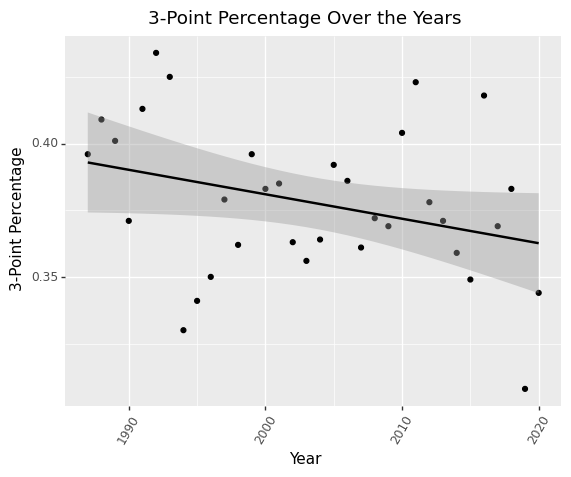

<ggplot: (298697024)>

In [19]:
(ggplot(threes, aes(x= 'year', y = 'fg3_pct')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('3-Point Percentage') +
ggtitle('3-Point Percentage Over the Years') +
geom_smooth(method = 'lm'))

It seems that the best teams are shooting more threes over time, yet making them at a worse percentage. Let's find the teams that were most efficient in their offenses.
Since the possesions statistic is not avaliable, we must calculate it using an estimation formula provided by https://www.sportsrec.com/calculate-teams-offensive-defensive-efficiencies-7775395.html

#### Possessions = Field Goals Attempted - Offensive Rebounds + Turnovers + (0.4 x free throws attempted)

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


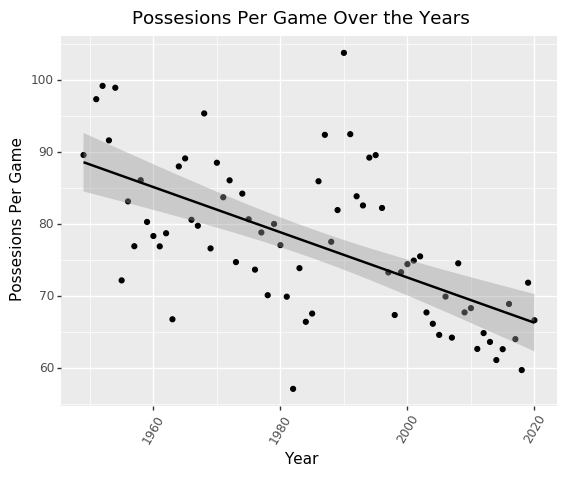

<ggplot: (7557356269)>

In [25]:
# We will be calculating possesions per game
efficiency = top_teams.filter(['g', 'pts', 'opp_pts', 'fga', 'fta', 'orb', 'opp_drb', 'fg', 'tov', 'opp_fga', 'opp_FTA', 'opp_orb', 'drb', 'opp_fg', 'opp_tov', 'opp_fta'])

# Every stat converted to its per game equivalency
efficiency = efficiency.div(efficiency['g'], axis=0)

# Add team name
efficiency.insert(0, 'team_name', top_teams['team_name'])

# Estimating possesions
# field goals attempted - offensive rebounds + turnovers + (0.4 x free throws attempted) = total number of possessions
possesions = efficiency['fga'] - efficiency['orb'] + efficiency['tov'] + (0.4 * efficiency['fta'])

# Insert columns for possessions and year
efficiency.insert(1, 'possesions', possesions)
efficiency['year'] = efficiency.index.astype(int)

# Plot
(ggplot(efficiency, aes(x= 'year', y = 'possesions')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('Possesions Per Game') +
ggtitle('Possesions Per Game Over the Years') +
geom_smooth(method = 'lm'))

Now that we have a possessions estimate, we can calculate offensive efficiency for each team. The simple formula can be found on https://www.nbastuffer.com/analytics101/offensive-efficiency/

#### Offensive Efficiency Formula=(Points Scored)/(Possessions)

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


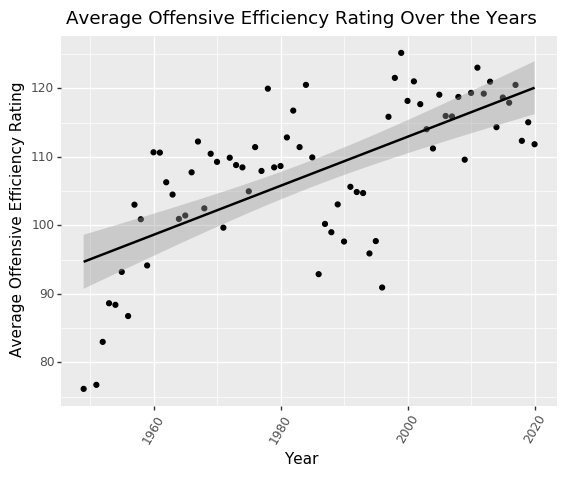

<ggplot: (7556751773)>

In [26]:
# Now we can calculate offensive efficiency
offensive = 100 * efficiency['pts'] / efficiency['possesions']
efficiency.insert(1, 'offensive', offensive)

# Plot
(ggplot(efficiency, aes(x= 'year', y = 'offensive')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('Average Offensive Efficiency Rating') +
ggtitle('Average Offensive Efficiency Rating Over the Years') +
geom_smooth(method = 'lm'))

In [27]:
off_eff = sm.ols('year~offensive', data=efficiency).fit()
off_eff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   year   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     56.28
Date:                Sat, 16 May 2020   Prob (F-statistic):           1.62e-10
Time:                        13:29:40   Log-Likelihood:                -294.08
No. Observations:                  71   AIC:                             592.2
Df Residuals:                      69   BIC:                             596.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1849.9345     18.094    102.237      0.000    1813.837    1886.032
offensive      1.2557      0.167      7.502      0.000       0.922       1.590
==============================================================================
Omnibus:                        8.157   Durbin-Watson:                   0.339
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                2.983
Skew:                           0.113   Prob(JB):                        0.225
Kurtosis:                       2.022   Cond. No.                     1.07e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [54]:
efficiency[efficiency['offensive'] == efficiency['offensive'].max()]

,team_name,offensive,possesions,g,pts,opp_pts,fga,fta,orb,opp_drb,fg,tov,opp_fga,opp_orb,drb,opp_fg,opp_tov,opp_fta,year
1999,Duke,125.166026,73.358974,1.0,91.820513,67.153846,62.102564,29.102564,15.051282,18.897436,31.897436,14.666667,63.74359,14.512821,27.128205,24.923077,17.692308,18.717949,1999


As predicted, team strategies have evolved to be much more offensively efficient. The lack of extra possessions caused by an opponent's turnover has sped up this shift in play. The best teams typically gain 1.25 offensive efficiency rating points each year. The peak of offensive efficiency in our dataset was by the 1999 Duke team with an offensive efficiency rating of 125.17.

Now, let's do the same thing with defensive efficiency, calculating by the formula found on https://www.nbastuffer.com/analytics101/defensive-efficiency/

#### Defensive Efficiency = 100 * (Points Allowed / Possessions)

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


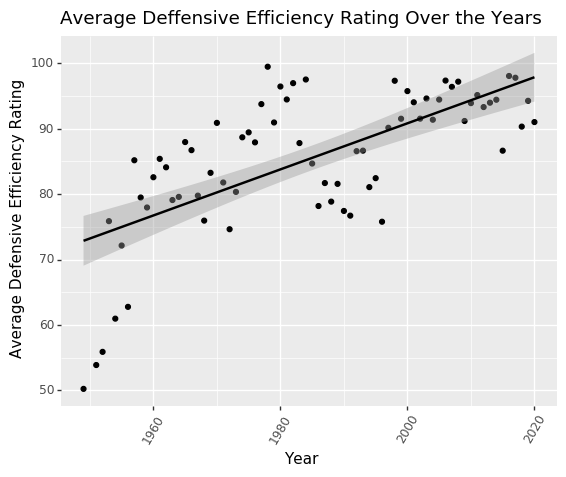

<ggplot: (7557216057)>

In [29]:
# Now let's calculate defesnive efficiency
#  Defensive Efficiency Fomula=100*(Points Allowed/Possessions)

defensive = 100 * efficiency['opp_pts'] / efficiency['possesions']
efficiency.insert(1, 'defensive', defensive)

(ggplot(efficiency, aes(x= 'year', y = 'defensive')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('Average Defensive Efficiency Rating') +
ggtitle('Average Deffensive Efficiency Rating Over the Years') +
geom_smooth(method = 'lm'))

In [30]:
# The higher the efficiency the more points given up per 100 possesions, so a better team has a low rating
efficiency[efficiency['defensive'] == efficiency['defensive'].min()]

,team_name,defensive,offensive,possesions,g,pts,opp_pts,fga,fta,orb,opp_drb,fg,tov,opp_fga,opp_orb,drb,opp_fg,opp_tov,opp_fta,year
1949,Kentucky,50.210029,76.135469,89.623529,1.0,68.235294,45.0,81.058824,21.411765,-0.029412,-0.029412,26.558824,-0.029412,65.176471,-0.029412,-0.029412,15.823529,45.0,22.235294,1949


In [31]:
def_eff = sm.ols('year~defensive', data=efficiency).fit()
def_eff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   year   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     58.59
Date:                Sat, 16 May 2020   Prob (F-statistic):           8.56e-11
Time:                        13:37:46   Log-Likelihood:                -293.44
No. Observations:                  71   AIC:                             590.9
Df Residuals:                      69   BIC:                             595.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1873.5340     14.673    127.683      0.000    1844.262    1902.806
defensive      1.3028      0.170      7.654      0.000       0.963       1.642
==============================================================================
Omnibus:                       17.578   Durbin-Watson:                   0.355
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                4.123
Skew:                          -0.089   Prob(JB):                        0.127
Kurtosis:                       1.833   Cond. No.                         697.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Defensive efficiency is a difficult statistic to comprehend, because the game has evolved into a much faster pace over the years. The most defensively efficient team is the 1949 Kentucky team. This is likely due to the slow pace of play and the lack of the 3 point shot.

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


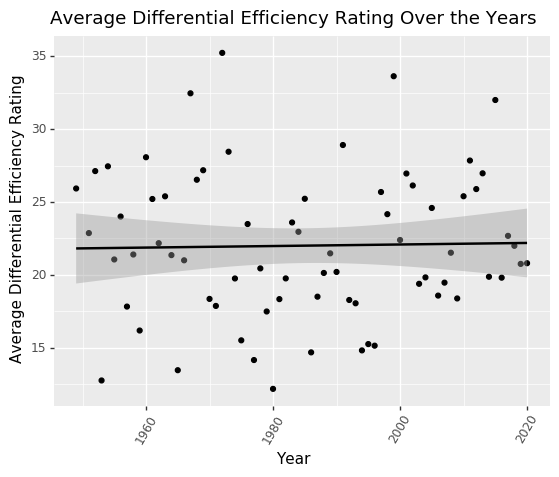

<ggplot: (7556773941)>

In [33]:
# Since both offensive and deffensive efficiencies are per points per 100 possesions, a simple differential will tell us which teams perform on average on both sides of the court
differenital = efficiency['offensive'] - efficiency['defensive']
efficiency.insert(1, 'differential', differenital)

(ggplot(efficiency, aes(x= 'year', y = 'differential')) +
geom_point() + 
theme(axis_text_x = element_text(angle=60)) +
xlab('Year') + 
ylab('Average Differential Efficiency Rating') +
ggtitle('Average Differential Efficiency Rating Over the Years') +
geom_smooth(method = 'lm'))

In [36]:
# The most efficient team on both sides of the court
efficiency[efficiency['differential'] == efficiency['differential'].max()]

,team_name,differential,defensive,offensive,possesions,g,pts,opp_pts,fga,fta,...,opp_drb,fg,tov,opp_fga,opp_orb,drb,opp_fg,opp_tov,opp_fta,year
1972,UCLA,35.227625,74.63611,109.863735,86.106667,1.0,94.6,64.266667,75.4,26.766667,...,-0.033333,38.0,-0.033333,66.766667,-0.033333,-0.033333,25.533333,-0.033333,19.266667,1972


In [48]:
# The least efficient team on both sides of the court
efficiency[efficiency['differential'] == efficiency['differential'].min()]

,team_name,differenital,defensive,offensive,possesions,g,pts,opp_pts,fga,fta,...,opp_drb,fg,tov,opp_fga,opp_orb,drb,opp_fg,opp_tov,opp_fta,year
1980,DePaul,12.180437,96.470915,108.651352,77.114286,1.0,83.785714,74.392857,67.5,24.035714,...,-0.035714,32.821429,-0.035714,70.178571,-0.035714,-0.035714,31.392857,-0.035714,16.285714,1980


While the efficiency differential doesn't really show a trend, it does separate the best of the best teams. The 1972 UCLA Bruins had the best efficiency differential in our dataset, and went on to win the 1972 National Championship. More recently, the 2015 Kentucky team that was extremely efficient with a differential of ~32 made a Final Four run. On the other hand, the 1980 DePaul team had an awful efficiency differential, and was eliminated from the NCAA tournament in the Round of 32.